# Applied Network Science extension

### Import libraries

In [1]:
import skfda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

os.chdir('/Users/ltesta/Documents/GitHub/crunch_net/ANS/data/datasets/cb')

### Own methods and plot settings

In [2]:
def extract_window(time_window):
    data_aligned=pd.DataFrame()
    for col in data.columns:
        first_inv_year=data.loc[~data[col].isna(), col].index[0]
        if first_inv_year>1999 and first_inv_year<2021-time_window:
            x=data.loc[first_inv_year:,col].reset_index()
            data_aligned[col]=x[col]
    data_aligned=data_aligned.fillna(0)
    data_aligned=data_aligned.cumsum()
    data_export=data_aligned.loc[0:time_window-1,:]
    return data_export

# We run K-means 100 times per sector in order to "be sure" of clustering partitions
def functional_clustering(data):
    clusters={}
    kmeans=skfda.ml.clustering.KMeans(n_clusters=2, n_init=100)
    for sector in content.industry.unique():
        idx=content[content.industry==sector].index_x
        mat=data.loc[:,data.columns.isin(idx)]
        if mat.shape[1]>1:
            fdmat = skfda.FDataGrid(mat.transpose().to_numpy())
            labels=kmeans.fit_predict(fdmat)
            if kmeans.cluster_centers_.evaluate(0.5)[1]>kmeans.cluster_centers_.evaluate(0.5)[0]:
                for x in zip(mat.columns, labels):
                    clusters[x[0]]=x[1]
            else:
                for x in zip(mat.columns, labels):
                    clusters[x[0]]= 0 if x[1]==1 else 1
    return clusters

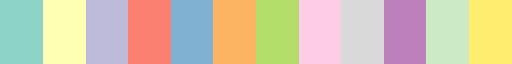

In [4]:
colors = [plt.cm.Set3(i) for i in range(20)]
high_regime=colors[0]
low_regime=colors[3]
default_color=colors[4]
plt.cm.get_cmap('Set3')

### Data preprocessing

In [5]:
cb1 = pd.read_csv('cb1.csv')
cb2 = pd.read_csv('cb2.csv')
cb3 = pd.read_csv('cb3.csv')
cb = cb1.append(cb2)
cb = cb.append(cb3)
cb.index = range(len(cb))
cb['date_my'] = (pd.to_datetime(cb['date'],format='%m/%d/%Y', errors='coerce')).dt.to_period('m')
cb['date_y'] = (pd.to_datetime(cb['date'],format='%m/%d/%Y', errors='coerce')).dt.to_period('y')

nodes_org = cb[['target_name', 'target_ID']].drop_duplicates()
nodes_org['bipartite'] = 1
nodes_inv = cb[['investors_name', 'investor_id']].drop_duplicates()
nodes_org = nodes_org.rename(columns={"target_name": "node", "target_country": "country", 
                                      "target_continent": "continent", "industry":"industry",
                                     "target_ID":"index"})
nodes_inv = nodes_inv.rename(columns={"investors_name": "node","investor_country": "country", 
                                      "investor_continent": "continent", "investor_type":"industry","investor_id":'index' })
nodes_inv['bipartite'] = 0
nodes = nodes_org.append(nodes_inv, ignore_index= True)
nodes['id'] = nodes.index

numbers = cb.groupby(['target_name','stage'], as_index = False).count()[['target_name','stage','investors_name']].rename(columns={"investors_name": "investor_numbers"})
cb_new = pd.merge(cb, numbers,  how='left', left_on=['target_name','stage'], right_on = ['target_name','stage'])
cb_new = pd.merge(cb_new, nodes[nodes['bipartite']== 1],  how='left', left_on=['target_name','target_ID'], right_on = ['node','index'])
cb_new = pd.merge(cb_new, nodes[nodes['bipartite']== 0],  how='left', left_on=['investors_name','investor_id'], right_on = ['node','index'])

data=cb_new[['target_name', 'industry', 'index_x', 'date_y', 'size_real', 'target_founded', 'target_status', 'round_simp']]
data.date_y=data.date_y.dt.year
a=data.groupby(['round_simp']).count()
a['target_name']=a.target_name/data.shape[0]
remove=['Asset Sale', 'Bridge', 'Dead', 'Debt', 'Distressed & Special Situation', 'Leveraged Buyout', 'Line of Credit', 
 'Loan', 'Management Buyout', 'Milestone Payment', 'Other Investors', 'Portfolio Merger', 'Portfolio NewCo',
 'Secondary Market', 'Shareholder Liquidity']

data=data[data.size_real>0]
data=data[~data.target_founded.isna()]
data=data[data.date_y<2021]
data=data.loc[data.industry.isna()==False,]
data=data.loc[~data.round_simp.isin(remove)]

content=data[['industry','index_x', 'target_name', 'target_founded', 'target_status']].drop_duplicates()
content['alive']=np.where(content.target_status.isin(['Alive / Active']),1,0)

data=data.groupby(['index_x','target_name','date_y']).mean().reset_index()
data=data.pivot('date_y','index_x','size_real')

 /Users/ltesta/opt/anaconda3/envs/netfda/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [6]:
content.head()

,industry,index_x,target_name,target_founded,target_status,alive
8838,Biotechnology,102322.0,Genentech,1976.0,Acquired,0
8883,Disease Diagnosis,535053.0,Queue Systems,1981.0,Acquired,0
8890,Biotechnology,537900.0,Seragen,1979.0,IPO / Went public,0
8900,Disease Diagnosis,552001.0,Zymark,1981.0,Acquired,0
8903,Medical Devices & Equipment,495217.0,Amarel Precision Instrume,1980.0,Alive / Active,1


In [7]:
content.industry.value_counts()

Medical Devices & Equipment                 3068
Biotechnology                               2612
Internet Software & Services                1344
Medical Facilities & Services               1321
Drug Development                            1058
Mobile Software & Services                   991
Pharmaceuticals / Drugs                      842
Healthcare Software                          812
Disease Diagnosis                            358
Drug Discovery                               339
Medical Equipment & Supplies                 250
Health & Wellness (non-internet/mobile)…     220
Drug Delivery                                186
Drug Manufacturing                           144
Stealth Mode                                 127
Dental Products & Services                   102
Medical Product Distribution                  40
Healthcare Plans                              33
Alternative Medicine                          31
Medical Information                           30
Elective & Aesthetic

### Processing

#### Window analysis

In [14]:
percentage=[]
for size in range(5,13):
    data_size=extract_window(size)
    clusters=functional_clustering(data_size)
    percentage.append(sum(clusters.values())/len(clusters.values()))

 /Users/ltesta/opt/anaconda3/envs/netfda/lib/python3.7/site-packages/ipykernel_launcher.py:7: PerformanceWarning:DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [10]:
win_big=[]
for size in range(5,13):
    data_size=extract_window(size)
    win_big.append(data_size.shape[1])

 /Users/ltesta/opt/anaconda3/envs/netfda/lib/python3.7/site-packages/ipykernel_launcher.py:7: PerformanceWarning:DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


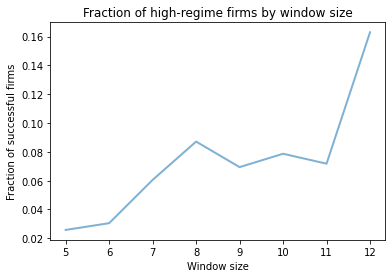

In [17]:
fig, ax = plt.subplots(1,1, figsize=(6, 4))
plt.plot(range(5,13), percentage, c=default_color, linewidth=2)
plt.xlabel('Window size')
plt.ylabel('Fraction of successful firms')
plt.title('Fraction of high-regime firms by window size')

os.chdir('/Users/ltesta/Documents/GitHub/crunch_net/ANS/plots')
plt.savefig('fraction_high_regime.pdf', bbox_inches="tight")

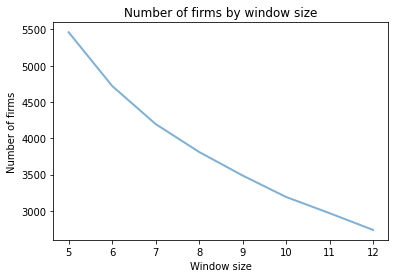

In [18]:
fig, ax = plt.subplots(1,1, figsize=(6, 4))
plt.plot(range(5,13), win_big, c=default_color, linewidth=2)
plt.xlabel('Window size')
plt.ylabel('Number of firms')
plt.title('Number of firms by window size')

os.chdir('/Users/ltesta/Documents/GitHub/crunch_net/ANS/plots')
plt.savefig('number_firms_window_size.pdf', bbox_inches="tight")

#### Logistic regression

In [15]:
size=8
data_size=extract_window(size)

 /Users/ltesta/opt/anaconda3/envs/netfda/lib/python3.7/site-packages/ipykernel_launcher.py:7: PerformanceWarning:DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [19]:
data_size.head()

,29.0,64.0,65.0,85.0,102.0,109.0,116.0,184.0,206.0,219.0,...,551800.0,551970.0,552007.0,559679.0,576878.0,580146.0,614199.0,627608.0,632716.0,660680.0
0,2.133636e+07,3.297188e+07,2.619628e+05,1.715246e+07,4.855286e+06,1.125003e+07,4.770676e+07,7.419990e+06,1.349089e+07,5.074074e+06,...,2.315493e+06,9.800061e+06,1.934602e+06,9.965976e+06,94073.077807,1.319827e+05,2.829517e+06,1.495019e+07,5.087145e+06,1.454473e+08
1,2.133636e+07,3.297188e+07,6.372779e+05,8.390408e+07,2.217543e+07,2.121909e+07,4.770676e+07,7.419990e+06,1.349089e+07,5.074074e+06,...,5.366718e+06,9.800061e+06,1.934602e+06,9.965976e+06,94073.077807,1.079009e+06,4.711450e+06,4.323839e+07,5.087145e+06,1.454473e+08
2,3.899474e+07,3.297188e+07,1.933739e+06,8.390408e+07,2.217543e+07,2.121909e+07,4.770676e+07,3.498412e+07,4.095466e+07,5.074074e+06,...,5.366718e+06,9.800061e+06,1.934602e+06,9.965976e+06,94073.077807,1.079009e+06,4.711450e+06,5.437382e+07,5.087145e+06,1.454473e+08
3,3.899474e+07,8.312734e+07,2.816119e+06,8.390408e+07,6.205683e+07,2.121909e+07,1.363433e+08,3.498412e+07,4.095466e+07,5.074074e+06,...,5.366718e+06,9.800061e+06,1.934602e+06,9.965976e+06,94073.077807,1.079009e+06,4.711450e+06,2.467892e+08,5.087145e+06,1.454473e+08
4,6.316233e+07,1.430096e+08,5.913046e+06,8.390408e+07,6.205683e+07,2.121909e+07,1.363433e+08,3.498412e+07,7.249256e+07,5.074074e+06,...,5.366718e+06,9.800061e+06,1.934602e+06,9.965976e+06,94073.077807,1.079009e+06,4.711450e+06,2.467892e+08,5.087145e+06,1.454473e+08


In [20]:
clusters=functional_clustering(data_size)

In [21]:
print('Percentage of successful firms:', 100*sum(clusters.values())/len(clusters.values()), '%')

Percentage of successful firms: 8.711624245604828 %


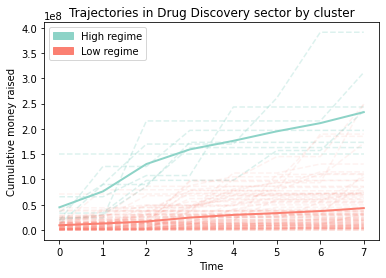

In [22]:
toplot=data_size.loc[:, data_size.columns.isin(content[content.industry=='Drug Discovery'].index_x)]
toplot1=toplot.loc[:, toplot.columns.isin([x for x in clusters.keys() if clusters[x]==1])]
toplot0=toplot.loc[:, toplot.columns.isin([x for x in clusters.keys() if clusters[x]==0])]

fig, ax = plt.subplots(1,1, figsize=(6, 4))
plt.plot(toplot1, c=high_regime, alpha=0.3, linestyle='--')
plt.plot(toplot0, c=low_regime, alpha=0.1, linestyle='--')
plt.plot(range(0,size), np.mean(toplot1, axis=1), c=high_regime, linewidth=2)
plt.plot(range(0,size), np.mean(toplot0, axis=1), c=low_regime, linewidth=2)
high_patch = mpatches.Patch(color=high_regime, label='High regime')
low_patch = mpatches.Patch(color=low_regime, label='Low regime')
plt.legend(handles=[high_patch, low_patch])
plt.xlabel('Time')
plt.xticks(range(0,size))
plt.ylabel('Cumulative money raised')
plt.title('Trajectories in Drug Discovery sector by cluster')

os.chdir('/Users/ltesta/Documents/GitHub/crunch_net/ANS/plots')
plt.savefig('drug_discovery_clustering_'+str(size)+'.pdf', bbox_inches="tight")

In [23]:
toplot.shape

(8, 108)

#### Linear regression

In [147]:
cumulate=data_size.loc[data_size.shape[0]-1,:]

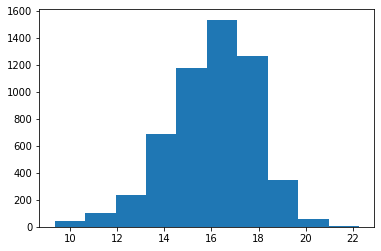

In [148]:
plt.hist(np.log(cumulate))
plt.show()

Function-on-scalar regression is not supported. We have to save our functional object matrix and rely on R "refund" package